In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
from zipfile import ZipFile
import PIL

import tensorflow as tf


In [2]:
train_dir = pathlib.Path("/Users/admin/Desktop/Fruit_classifier/fruits-360/Training")
test_dir = pathlib.Path("/Users/admin/Desktop/Fruit_classifier/fruits-360/Test")

In [3]:
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count


67692

In [4]:
image_count1 = len(list(test_dir.glob('*/*.jpg')))
image_count1

22688

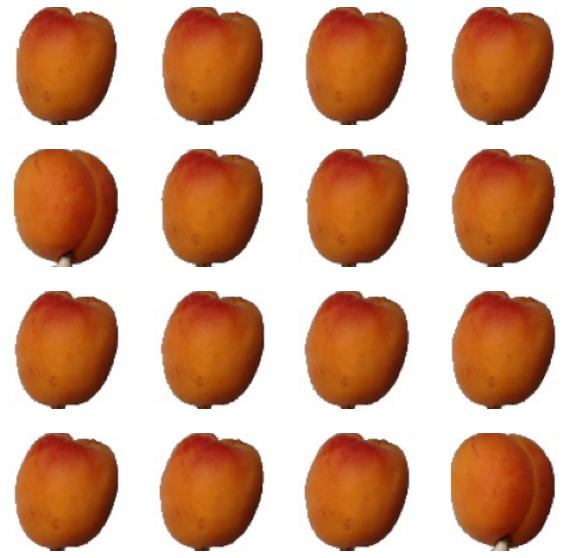

In [5]:
fruits = list(train_dir.glob('Apricot/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    img = PIL.Image.open(str(fruits[i+40]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [6]:
batch_size = 32
img_height = 100
img_width = 100


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [9]:
class_names=train_ds.class_names
num_class = len(class_names)

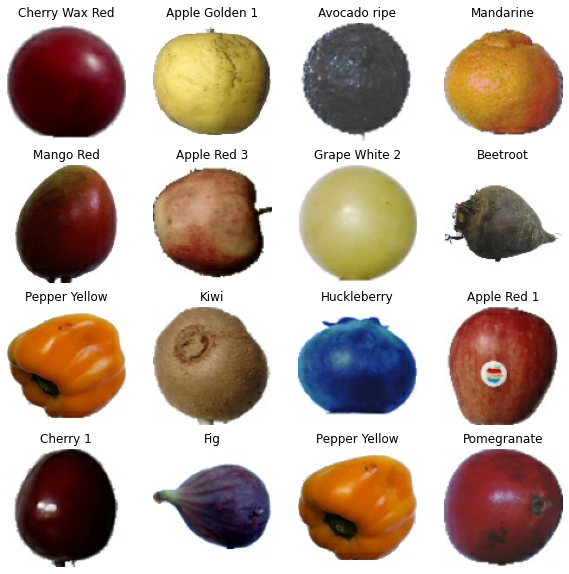

In [10]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [14]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

In [15]:
base_model.trainable =  False

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_class)

In [19]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [22]:
model.evaluate(val_ds)

424/424 [==============================] - 60s 65ms/step - loss: 6.2918 - accuracy: 0.0015


[6.2918195724487305, 0.001477323123253882]

In [23]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
1693/1693 [==============================] - 262s 135ms/step - loss: 1.2773 - accuracy: 0.7245 - val_loss: 0.2837 - val_accuracy: 0.9654
Epoch 2/10
1693/1693 [==============================] - 294s 174ms/step - loss: 0.2167 - accuracy: 0.9606 - val_loss: 0.1170 - val_accuracy: 0.9867
Epoch 3/10
1693/1693 [==============================] - 272s 160ms/step - loss: 0.1048 - accuracy: 0.9826 - val_loss: 0.0645 - val_accuracy: 0.9935
Epoch 4/10
1693/1693 [==============================] - 222s 131ms/step - loss: 0.0627 - accuracy: 0.9899 - val_loss: 0.0398 - val_accuracy: 0.9969
Epoch 5/10
1693/1693 [==============================] - 221s 131ms/step - loss: 0.0420 - accuracy: 0.9936 - val_loss: 0.0281 - val_accuracy: 0.9982
Epoch 6/10
1693/1693 [==============================] - 197s 116ms/step - loss: 0.0297 - accuracy: 0.9957 - val_loss: 0.0207 - val_accuracy: 0.9987
Epoch 7/10
1693/1693 [==============================] - 216s 127ms/step - loss: 0.0221 - accuracy: 0.9973 - val_

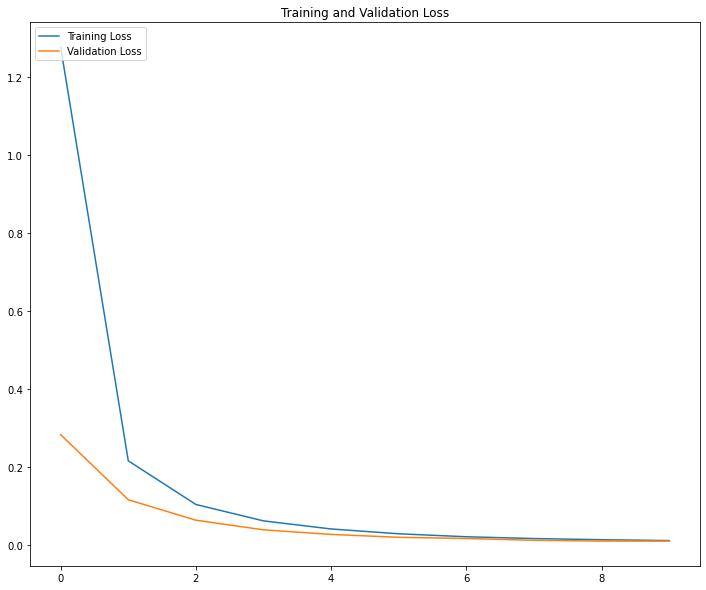

In [24]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
np.argmin(val_loss)